# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [8]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [60]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [105]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [116]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for fcc_w
Gradient check passed!
Checking gradient for fcc_b
Gradient check passed!
Checking gradient for fcc_hidden_w
Gradient check passed!
Checking gradient for fcc_hidden_b
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [122]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for fcc_w
Gradient check passed!
Checking gradient for fcc_b
Gradient check passed!
Checking gradient for fcc_hidden_w
Gradient check passed!
Checking gradient for fcc_hidden_b
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [130]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 



0.03333333333333333

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [164]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302716, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302364, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302129, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301851, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303047, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302661, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302178, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302954, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302944, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302741, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302108, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303141, Train accuracy: 0.196667, val accuracy: 0.206000


KeyboardInterrupt: 

In [ ]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [166]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.310801, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.314636, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.307507, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.288038, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.280017, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.284665, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.297300, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.298616, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.277225, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.307116, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.312064, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.285115, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.310139, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.301526, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.304067, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.320880, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [172]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.329550, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.322522, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.318450, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.308380, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.308427, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.318974, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.303303, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.306627, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.310939, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.310149, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.315673, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.308980, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.301948, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.308181, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.307880, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.300578, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [255]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.330621, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.319432, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.306828, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.294552, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299224, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.287942, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.221626, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.291249, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.291523, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.032228, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.070104, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.294147, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.660860, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.024059, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.708033, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.509826, Train acc

Loss: 1.210066, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.418675, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.446030, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.273200, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.161493, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.488420, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.444331, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.441828, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.378855, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.344501, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.475302, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.447199, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.245256, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.525256, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.188765, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.113775, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

Loss: 2.309453, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.272458, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.175247, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.179428, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.342082, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.100146, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.771892, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 1.470512, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 2.213795, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.064524, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.848417, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 0.173987, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 1.369899, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 0.331768, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 0.925607, Train accuracy: 0.866667, val accuracy: 0.066667
Loss: 0.417128, Train acc

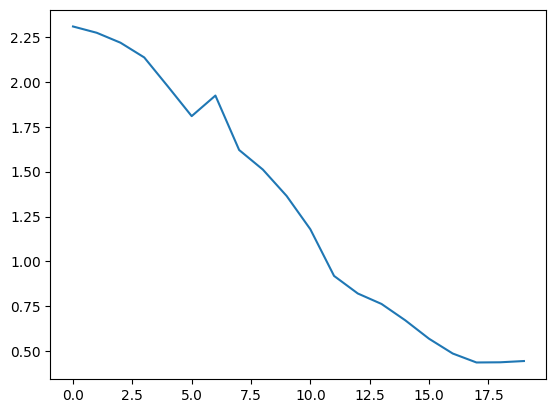

In [282]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 3e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
#trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=20, batch_size=5)
trainer = Trainer(model, dataset, MomentumSGD(momentum = 0.99), learning_rate=1e-1, num_epochs=20, batch_size=5,learning_rate_decay=0.87 )

loss_history, train_history, val_history = trainer.fit()
plt.plot(loss_history)

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [667]:
np.arange(2,6,1)

array([2, 3, 4, 5])

In [687]:
# Let's train the best one-hidden-layer network we can

learning_rates = [10**-(x - np.random.random(1)[0]) for x in np.arange(2, 6, 1)] #1e-4
reg_strengths = [10**-(x - np.random.random(1)[0]) for x in np.arange(1,7,2)]#1e-3
momentums = (np.arange(.9, 1, .03) + np.random.random(4)*.01).tolist()
learning_rate_decays = [.8,.9,0.99]
hidden_layer_sizes = [150, 200]
batch_sizes = [300, 400]
num_epochs = 200
#batch_size = 64

best_classifier = None
best_val_accuracy = 0

# model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 200, reg = 3e-3)
# dataset = Dataset(train_X, train_y, val_X, val_y)
# # TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
# #trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=20, batch_size=5)
# trainer = Trainer(model, dataset, MomentumSGD(momentum = 0.99), learning_rate=1e-1, num_epochs=20, batch_size=5,learning_rate_decay=0.87 )

# loss_history, train_history, val_history = trainer.fit()



loss_history = []
train_history = []
val_history = []
best_params = dict()
all_params_hist = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
counter = 0
for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        for momentum in momentums:
            for decay in learning_rate_decays:
                for hl_size in hidden_layer_sizes:
                    for batch_size in batch_sizes:
                        counter+=1
                        print(counter)
                        model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hl_size, reg = reg_strength)
                        dataset = Dataset(train_X, train_y, val_X, val_y)
                        # TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
                        #trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=20, batch_size=5)
                        trainer = Trainer(model, dataset, MomentumSGD(momentum = momentum), learning_rate=learning_rate, num_epochs=15, batch_size=batch_size,learning_rate_decay=decay )
                        model_loss_hist, model_train_history, model_val_history = trainer.fit()
                        print(model_val_history[-1])
                        params_hist = dict()
                        params_hist['learning_rate'] = learning_rate
                        params_hist['reg_strength'] = reg_strength
                        params_hist['momentum'] = momentum
                        params_hist['decay'] = decay
                        params_hist['hl_size'] = hl_size
                        params_hist['model_loss'] = model_loss_hist
                        params_hist['model_train'] = model_train_history
                        params_hist['model_val'] = model_val_history
                        params_hist['batch_size'] = batch_size
                        all_params_hist += [params_hist]

                        if model_val_history[-1] > best_val_accuracy:
                            best_val_accuracy = model_val_history[-1]
                            best_classifier = model
                            best_params['learning_rate'] = learning_rate
                            best_params['reg_strength'] = reg_strength
                            best_params['momentum'] = momentum
                            best_params['decay'] = decay
                            best_params['hl_size'] = hl_size
                            best_params['batch_size'] = batch_size
# plt.figure(figsize=(15, 7))
# plt.subplot(211)
# plt.title("Loss")
# plt.plot(model_loss_hist)
# plt.subplot(212)
# plt.title("Train/validation accuracy")
# plt.plot(model_train_history)
# plt.plot(model_val_history)
    


print('best validation accuracy achieved: %f' % best_val_accuracy)

1
Loss: 5.160168, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.340284, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319647, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293964, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297991, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299878, Train accuracy: 0.196667, val accuracy: 0.206000
0.206
2
Loss: 2.638589, Train accuracy: 0.160889, val accuracy: 0.180000
Loss: 4.694465, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.540323, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315524, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299060, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298853, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297399, Train accuracy: 0.196667, val accuracy: 0.206000
0.206
3
Loss: 6.053567, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.349523, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2

Loss: 18.530818, Train accuracy: 0.179000, val accuracy: 0.182000
Loss: 2.669376, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.493946, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.430459, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.328298, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303839, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295877, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294904, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298972, Train accuracy: 0.196667, val accuracy: 0.206000
0.206
19
Loss: 14.251003, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 3.194044, Train accuracy: 0.186556, val accuracy: 0.195000
Loss: 2.706687, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319506, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308107, Train accuracy: 0.148333, val accuracy: 0.140000
Loss: 2.303501, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298331

Loss: 2.316719, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.343681, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.329371, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305115, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297425, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299902, Train accuracy: 0.196667, val accuracy: 0.206000
0.206
30
Loss: 4.745874, Train accuracy: 0.195444, val accuracy: 0.203000
Loss: 58.359889, Train accuracy: 0.169222, val accuracy: 0.167000
Loss: 5.528531, Train accuracy: 0.121667, val accuracy: 0.144000
Loss: 4.003104, Train accuracy: 0.158556, val accuracy: 0.158000
Loss: 4.795752, Train accuracy: 0.194222, val accuracy: 0.203000
Loss: 3.427228, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.479121, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.336505, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.520359, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.365816,

Loss: 9.367790, Train accuracy: 0.147333, val accuracy: 0.168000
Loss: 20.421472, Train accuracy: 0.118778, val accuracy: 0.146000
Loss: 3.239208, Train accuracy: 0.125667, val accuracy: 0.127000
Loss: 57.024008, Train accuracy: 0.183889, val accuracy: 0.174000
Loss: 74.210368, Train accuracy: 0.151556, val accuracy: 0.149000
Loss: 21.665113, Train accuracy: 0.176889, val accuracy: 0.170000
Loss: 18.849574, Train accuracy: 0.086667, val accuracy: 0.086000
Loss: 44.595927, Train accuracy: 0.089778, val accuracy: 0.092000
Loss: 39.358133, Train accuracy: 0.174111, val accuracy: 0.171000
Loss: 30.968981, Train accuracy: 0.166444, val accuracy: 0.154000
Loss: 22.093942, Train accuracy: 0.161333, val accuracy: 0.156000
Loss: 7.955476, Train accuracy: 0.185444, val accuracy: 0.196000
Loss: 4.617033, Train accuracy: 0.167333, val accuracy: 0.184000
Loss: 14.533877, Train accuracy: 0.141889, val accuracy: 0.129000
0.129
42
Loss: 6.278481, Train accuracy: 0.134444, val accuracy: 0.153000
Loss: 

Loss: 1.481109, Train accuracy: 0.714444, val accuracy: 0.688000
Loss: 1.427308, Train accuracy: 0.727000, val accuracy: 0.697000
Loss: 1.404707, Train accuracy: 0.738222, val accuracy: 0.706000
Loss: 1.259081, Train accuracy: 0.746111, val accuracy: 0.722000
Loss: 1.288505, Train accuracy: 0.752444, val accuracy: 0.715000
Loss: 1.211053, Train accuracy: 0.756444, val accuracy: 0.723000
Loss: 1.093021, Train accuracy: 0.761222, val accuracy: 0.720000
Loss: 1.265139, Train accuracy: 0.761111, val accuracy: 0.720000
Loss: 1.275258, Train accuracy: 0.760333, val accuracy: 0.722000
Loss: 1.283615, Train accuracy: 0.764111, val accuracy: 0.723000
0.723
52
Loss: 2.431856, Train accuracy: 0.313111, val accuracy: 0.304000
Loss: 2.046832, Train accuracy: 0.507889, val accuracy: 0.499000
Loss: 1.786298, Train accuracy: 0.595444, val accuracy: 0.583000
Loss: 1.693245, Train accuracy: 0.651778, val accuracy: 0.626000
Loss: 1.638018, Train accuracy: 0.680444, val accuracy: 0.642000
Loss: 1.419467, 

Loss: 2.489615, Train accuracy: 0.278778, val accuracy: 0.269000
Loss: 1.999500, Train accuracy: 0.521000, val accuracy: 0.476000
Loss: 1.836100, Train accuracy: 0.611000, val accuracy: 0.595000
Loss: 1.500869, Train accuracy: 0.654000, val accuracy: 0.630000
Loss: 1.463961, Train accuracy: 0.696333, val accuracy: 0.655000
Loss: 1.420155, Train accuracy: 0.722000, val accuracy: 0.680000
Loss: 1.389602, Train accuracy: 0.733333, val accuracy: 0.698000
Loss: 1.198051, Train accuracy: 0.745889, val accuracy: 0.704000
Loss: 1.220422, Train accuracy: 0.752444, val accuracy: 0.709000
Loss: 1.221735, Train accuracy: 0.760111, val accuracy: 0.696000
Loss: 1.088663, Train accuracy: 0.783556, val accuracy: 0.731000
Loss: 1.195278, Train accuracy: 0.800111, val accuracy: 0.734000
Loss: 1.145200, Train accuracy: 0.791778, val accuracy: 0.733000
Loss: 1.045821, Train accuracy: 0.797556, val accuracy: 0.731000
Loss: 1.144829, Train accuracy: 0.810222, val accuracy: 0.747000
0.747
61
Loss: 2.358087, 

Loss: 1.330856, Train accuracy: 0.732778, val accuracy: 0.697000
Loss: 1.245052, Train accuracy: 0.744444, val accuracy: 0.725000
Loss: 1.292999, Train accuracy: 0.768556, val accuracy: 0.720000
Loss: 1.130345, Train accuracy: 0.765222, val accuracy: 0.715000
Loss: 1.166303, Train accuracy: 0.770000, val accuracy: 0.716000
Loss: 1.039399, Train accuracy: 0.790111, val accuracy: 0.734000
Loss: 1.140804, Train accuracy: 0.797111, val accuracy: 0.742000
Loss: 1.083356, Train accuracy: 0.804111, val accuracy: 0.750000
Loss: 1.047115, Train accuracy: 0.815111, val accuracy: 0.747000
Loss: 1.039136, Train accuracy: 0.814333, val accuracy: 0.743000
0.743
69
Loss: 2.299207, Train accuracy: 0.395889, val accuracy: 0.380000
Loss: 1.726183, Train accuracy: 0.581000, val accuracy: 0.575000
Loss: 1.604295, Train accuracy: 0.663889, val accuracy: 0.650000
Loss: 1.351430, Train accuracy: 0.693000, val accuracy: 0.668000
Loss: 1.272096, Train accuracy: 0.705667, val accuracy: 0.695000
Loss: 1.147028, 

Loss: 0.962515, Train accuracy: 0.800000, val accuracy: 0.728000
Loss: 1.025406, Train accuracy: 0.803778, val accuracy: 0.744000
0.744
77
Loss: 2.245698, Train accuracy: 0.369222, val accuracy: 0.382000
Loss: 1.755909, Train accuracy: 0.571889, val accuracy: 0.567000
Loss: 1.446533, Train accuracy: 0.624778, val accuracy: 0.603000
Loss: 1.321422, Train accuracy: 0.685333, val accuracy: 0.666000
Loss: 1.528535, Train accuracy: 0.709333, val accuracy: 0.685000
Loss: 1.195992, Train accuracy: 0.736778, val accuracy: 0.692000
Loss: 1.130096, Train accuracy: 0.762889, val accuracy: 0.731000
Loss: 1.075623, Train accuracy: 0.732222, val accuracy: 0.689000
Loss: 1.055615, Train accuracy: 0.791222, val accuracy: 0.740000
Loss: 1.009074, Train accuracy: 0.792444, val accuracy: 0.731000
Loss: 1.050487, Train accuracy: 0.807667, val accuracy: 0.735000
Loss: 0.986853, Train accuracy: 0.826444, val accuracy: 0.755000
Loss: 0.927798, Train accuracy: 0.833667, val accuracy: 0.751000
Loss: 0.969080, 

Loss: 2.128975, Train accuracy: 0.559444, val accuracy: 0.559000
Loss: 1.840641, Train accuracy: 0.601333, val accuracy: 0.588000
0.588
89
Loss: 2.247978, Train accuracy: 0.396667, val accuracy: 0.375000
Loss: 2.364713, Train accuracy: 0.526222, val accuracy: 0.520000
Loss: 2.370163, Train accuracy: 0.589444, val accuracy: 0.566000
Loss: 2.508887, Train accuracy: 0.573333, val accuracy: 0.549000
0.549
90
Loss: 2.434739, Train accuracy: 0.256333, val accuracy: 0.264000
Loss: 1.872839, Train accuracy: 0.494000, val accuracy: 0.496000
Loss: 1.945023, Train accuracy: 0.540111, val accuracy: 0.534000
Loss: 2.153485, Train accuracy: 0.597778, val accuracy: 0.595000
0.595
91
Loss: 2.323203, Train accuracy: 0.369889, val accuracy: 0.366000
Loss: 1.847240, Train accuracy: 0.539333, val accuracy: 0.517000
Loss: 2.715589, Train accuracy: 0.572444, val accuracy: 0.555000
Loss: 2.998796, Train accuracy: 0.578333, val accuracy: 0.542000
0.542
92
Loss: 2.583184, Train accuracy: 0.296556, val accuracy

Loss: 1.932310, Train accuracy: 0.346444, val accuracy: 0.324000
Loss: 1.469764, Train accuracy: 0.578889, val accuracy: 0.568000
Loss: 1.206141, Train accuracy: 0.667222, val accuracy: 0.633000
Loss: 1.006833, Train accuracy: 0.690333, val accuracy: 0.668000
Loss: 1.069855, Train accuracy: 0.718444, val accuracy: 0.690000
Loss: 0.905470, Train accuracy: 0.735111, val accuracy: 0.689000
Loss: 0.800666, Train accuracy: 0.745778, val accuracy: 0.709000
Loss: 0.782137, Train accuracy: 0.775111, val accuracy: 0.718000
Loss: 0.767432, Train accuracy: 0.789000, val accuracy: 0.731000
Loss: 0.774868, Train accuracy: 0.800333, val accuracy: 0.742000
Loss: 0.669101, Train accuracy: 0.796889, val accuracy: 0.731000
Loss: 0.746839, Train accuracy: 0.812556, val accuracy: 0.740000
Loss: 0.712136, Train accuracy: 0.821111, val accuracy: 0.747000
Loss: 0.660683, Train accuracy: 0.824444, val accuracy: 0.744000
Loss: 0.597678, Train accuracy: 0.827778, val accuracy: 0.740000
0.74
104
Loss: 2.076735, 

Loss: 0.938778, Train accuracy: 0.754667, val accuracy: 0.713000
Loss: 0.829995, Train accuracy: 0.759000, val accuracy: 0.724000
Loss: 0.795058, Train accuracy: 0.780333, val accuracy: 0.728000
Loss: 0.651808, Train accuracy: 0.783667, val accuracy: 0.737000
Loss: 0.706438, Train accuracy: 0.794222, val accuracy: 0.746000
Loss: 0.787293, Train accuracy: 0.798444, val accuracy: 0.746000
Loss: 0.632668, Train accuracy: 0.804222, val accuracy: 0.742000
Loss: 0.643414, Train accuracy: 0.808000, val accuracy: 0.755000
Loss: 0.714535, Train accuracy: 0.808111, val accuracy: 0.749000
Loss: 0.621457, Train accuracy: 0.810444, val accuracy: 0.749000
0.749
112
Loss: 2.189355, Train accuracy: 0.304444, val accuracy: 0.298000
Loss: 1.473950, Train accuracy: 0.513778, val accuracy: 0.505000
Loss: 1.243181, Train accuracy: 0.630333, val accuracy: 0.602000
Loss: 1.064608, Train accuracy: 0.666222, val accuracy: 0.641000
Loss: 1.033273, Train accuracy: 0.707333, val accuracy: 0.682000
Loss: 0.980482,

Loss: 0.582161, Train accuracy: 0.831889, val accuracy: 0.727000
Loss: 0.598489, Train accuracy: 0.856444, val accuracy: 0.740000
Loss: 0.507916, Train accuracy: 0.847889, val accuracy: 0.738000
0.738
120
Loss: 1.932626, Train accuracy: 0.321778, val accuracy: 0.333000
Loss: 1.553806, Train accuracy: 0.545333, val accuracy: 0.515000
Loss: 1.136001, Train accuracy: 0.644556, val accuracy: 0.635000
Loss: 1.015173, Train accuracy: 0.673556, val accuracy: 0.645000
Loss: 0.918735, Train accuracy: 0.702778, val accuracy: 0.659000
Loss: 0.709677, Train accuracy: 0.737111, val accuracy: 0.695000
Loss: 0.854033, Train accuracy: 0.768000, val accuracy: 0.708000
Loss: 0.855562, Train accuracy: 0.780778, val accuracy: 0.732000
Loss: 0.737129, Train accuracy: 0.794444, val accuracy: 0.736000
Loss: 0.748015, Train accuracy: 0.778778, val accuracy: 0.722000
Loss: 0.791047, Train accuracy: 0.801111, val accuracy: 0.729000
Loss: 0.683128, Train accuracy: 0.794222, val accuracy: 0.703000
Loss: 0.569870,

Loss: 1.198472, Train accuracy: 0.619778, val accuracy: 0.612000
Loss: 0.992324, Train accuracy: 0.682778, val accuracy: 0.636000
Loss: 0.963823, Train accuracy: 0.726111, val accuracy: 0.683000
Loss: 0.798500, Train accuracy: 0.738111, val accuracy: 0.693000
Loss: 0.843561, Train accuracy: 0.768889, val accuracy: 0.715000
Loss: 0.812086, Train accuracy: 0.762000, val accuracy: 0.712000
Loss: 0.791230, Train accuracy: 0.792556, val accuracy: 0.727000
Loss: 0.535949, Train accuracy: 0.822111, val accuracy: 0.738000
Loss: 0.659141, Train accuracy: 0.814889, val accuracy: 0.743000
Loss: 0.567638, Train accuracy: 0.836111, val accuracy: 0.745000
Loss: 0.558584, Train accuracy: 0.848556, val accuracy: 0.750000
Loss: 0.518204, Train accuracy: 0.858556, val accuracy: 0.752000
Loss: 0.480380, Train accuracy: 0.861222, val accuracy: 0.743000
0.743
129
Loss: 1.948243, Train accuracy: 0.377667, val accuracy: 0.384000
Loss: 1.444574, Train accuracy: 0.588111, val accuracy: 0.582000
Loss: 1.154564,

Loss: 2.305618, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299777, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301481, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300268, Train accuracy: 0.196667, val accuracy: 0.206000
0.206
147
Loss: 50.199205, Train accuracy: 0.200667, val accuracy: 0.207000
Loss: 3.377494, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304776, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300087, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297186, Train accuracy: 0.196667, val accuracy: 0.206000
0.206
148
Loss: 99.375995, Train accuracy: 0.184000, val accuracy: 0.197000
Loss: 11.245506, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 3.003409, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.389333, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320966, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305412, Train accuracy: 0.196667, val accuracy: 0.206000
Lo

Loss: 2.381503, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.324278, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300718, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297024, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295636, Train accuracy: 0.196667, val accuracy: 0.206000
0.206
165
Loss: 14.522900, Train accuracy: 0.197111, val accuracy: 0.206000
Loss: 8.833039, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.501630, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.455830, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302524, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300980, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298988, Train accuracy: 0.196667, val accuracy: 0.206000
0.206
166
Loss: 51.019105, Train accuracy: 0.206333, val accuracy: 0.214000
Loss: 4.742710, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 6.865243, Train accuracy: 0.196667, val accuracy: 0.206000
Los

Loss: 8.883030, Train accuracy: 0.150444, val accuracy: 0.165000
Loss: 152.220290, Train accuracy: 0.168222, val accuracy: 0.173000
Loss: 30.524090, Train accuracy: 0.108444, val accuracy: 0.121000
Loss: 93.018878, Train accuracy: 0.176333, val accuracy: 0.185000
0.185
186
Loss: 15.263811, Train accuracy: 0.197000, val accuracy: 0.207000
Loss: 156.529237, Train accuracy: 0.181444, val accuracy: 0.177000
Loss: 81.134250, Train accuracy: 0.202333, val accuracy: 0.201000
Loss: 30.652733, Train accuracy: 0.080667, val accuracy: 0.076000
Loss: 128.060996, Train accuracy: 0.155333, val accuracy: 0.152000
0.152
187
Loss: 10.932824, Train accuracy: 0.175333, val accuracy: 0.184000
Loss: 199.468653, Train accuracy: 0.175556, val accuracy: 0.179000
Loss: 39.354219, Train accuracy: 0.095667, val accuracy: 0.112000
Loss: 121.600026, Train accuracy: 0.188778, val accuracy: 0.185000
0.185
188
Loss: 19.391233, Train accuracy: 0.197111, val accuracy: 0.206000
Loss: 205.656074, Train accuracy: 0.165222

Loss: 2.607268, Train accuracy: 0.246889, val accuracy: 0.244000
Loss: 2.553471, Train accuracy: 0.253000, val accuracy: 0.252000
Loss: 2.604751, Train accuracy: 0.257889, val accuracy: 0.262000
Loss: 2.541473, Train accuracy: 0.261444, val accuracy: 0.265000
Loss: 2.523359, Train accuracy: 0.266111, val accuracy: 0.263000
Loss: 2.513106, Train accuracy: 0.270889, val accuracy: 0.273000
Loss: 2.542906, Train accuracy: 0.276444, val accuracy: 0.280000
Loss: 2.535211, Train accuracy: 0.282000, val accuracy: 0.280000
Loss: 2.505337, Train accuracy: 0.286111, val accuracy: 0.285000
Loss: 2.511081, Train accuracy: 0.291000, val accuracy: 0.292000
Loss: 2.474622, Train accuracy: 0.293667, val accuracy: 0.296000
Loss: 2.517823, Train accuracy: 0.296667, val accuracy: 0.301000
0.301
200
Loss: 2.751172, Train accuracy: 0.171556, val accuracy: 0.149000
Loss: 2.666450, Train accuracy: 0.200111, val accuracy: 0.195000
Loss: 2.650330, Train accuracy: 0.218889, val accuracy: 0.208000
Loss: 2.621764,

Loss: 2.512088, Train accuracy: 0.281778, val accuracy: 0.278000
Loss: 2.479931, Train accuracy: 0.283667, val accuracy: 0.282000
Loss: 2.533507, Train accuracy: 0.285444, val accuracy: 0.284000
Loss: 2.494607, Train accuracy: 0.286111, val accuracy: 0.284000
Loss: 2.472614, Train accuracy: 0.288556, val accuracy: 0.286000
0.286
208
Loss: 2.692256, Train accuracy: 0.171333, val accuracy: 0.181000
Loss: 2.666590, Train accuracy: 0.204333, val accuracy: 0.207000
Loss: 2.606594, Train accuracy: 0.221333, val accuracy: 0.227000
Loss: 2.611924, Train accuracy: 0.224556, val accuracy: 0.231000
Loss: 2.660981, Train accuracy: 0.229333, val accuracy: 0.237000
Loss: 2.570206, Train accuracy: 0.235333, val accuracy: 0.243000
Loss: 2.623829, Train accuracy: 0.241667, val accuracy: 0.248000
Loss: 2.540932, Train accuracy: 0.246889, val accuracy: 0.257000
Loss: 2.581137, Train accuracy: 0.248111, val accuracy: 0.261000
Loss: 2.608080, Train accuracy: 0.251556, val accuracy: 0.265000
Loss: 2.500771,

Loss: 2.687620, Train accuracy: 0.207444, val accuracy: 0.211000
Loss: 2.627601, Train accuracy: 0.235778, val accuracy: 0.240000
Loss: 2.602927, Train accuracy: 0.245222, val accuracy: 0.253000
Loss: 2.577250, Train accuracy: 0.249000, val accuracy: 0.253000
Loss: 2.493478, Train accuracy: 0.279333, val accuracy: 0.281000
Loss: 2.511701, Train accuracy: 0.282000, val accuracy: 0.284000
Loss: 2.487664, Train accuracy: 0.306667, val accuracy: 0.310000
Loss: 2.440380, Train accuracy: 0.323667, val accuracy: 0.325000
Loss: 2.481074, Train accuracy: 0.341444, val accuracy: 0.349000
Loss: 2.384101, Train accuracy: 0.359333, val accuracy: 0.367000
Loss: 2.368709, Train accuracy: 0.374556, val accuracy: 0.379000
Loss: 2.339407, Train accuracy: 0.392333, val accuracy: 0.397000
Loss: 2.301168, Train accuracy: 0.408333, val accuracy: 0.419000
Loss: 2.240269, Train accuracy: 0.426889, val accuracy: 0.437000
0.437
217
Loss: 2.623156, Train accuracy: 0.190444, val accuracy: 0.193000
Loss: 2.494474,

Loss: 2.466622, Train accuracy: 0.286222, val accuracy: 0.286000
Loss: 2.499146, Train accuracy: 0.292222, val accuracy: 0.297000
Loss: 2.431576, Train accuracy: 0.310111, val accuracy: 0.311000
Loss: 2.409257, Train accuracy: 0.320111, val accuracy: 0.319000
Loss: 2.363944, Train accuracy: 0.335333, val accuracy: 0.337000
Loss: 2.400960, Train accuracy: 0.346667, val accuracy: 0.339000
Loss: 2.374104, Train accuracy: 0.358333, val accuracy: 0.362000
Loss: 2.255261, Train accuracy: 0.368333, val accuracy: 0.374000
Loss: 2.277889, Train accuracy: 0.374667, val accuracy: 0.382000
0.382
225
Loss: 2.611198, Train accuracy: 0.201000, val accuracy: 0.217000
Loss: 2.534870, Train accuracy: 0.237444, val accuracy: 0.252000
Loss: 2.489192, Train accuracy: 0.256889, val accuracy: 0.271000
Loss: 2.410075, Train accuracy: 0.280556, val accuracy: 0.285000
Loss: 2.337950, Train accuracy: 0.319222, val accuracy: 0.327000
Loss: 2.251168, Train accuracy: 0.358444, val accuracy: 0.364000
Loss: 2.193357,

Loss: 2.153126, Train accuracy: 0.419111, val accuracy: 0.399000
Loss: 2.249693, Train accuracy: 0.437222, val accuracy: 0.423000
Loss: 2.074249, Train accuracy: 0.453556, val accuracy: 0.439000
Loss: 2.082433, Train accuracy: 0.464889, val accuracy: 0.451000
0.451
233
Loss: 2.605274, Train accuracy: 0.211778, val accuracy: 0.213000
Loss: 2.540268, Train accuracy: 0.217333, val accuracy: 0.216000
Loss: 2.495563, Train accuracy: 0.250111, val accuracy: 0.249000
Loss: 2.396123, Train accuracy: 0.274556, val accuracy: 0.280000
Loss: 2.299321, Train accuracy: 0.340111, val accuracy: 0.341000
Loss: 2.163514, Train accuracy: 0.370556, val accuracy: 0.359000
Loss: 2.047026, Train accuracy: 0.429333, val accuracy: 0.422000
Loss: 1.990354, Train accuracy: 0.472222, val accuracy: 0.459000
Loss: 1.940484, Train accuracy: 0.511667, val accuracy: 0.505000
Loss: 1.823637, Train accuracy: 0.543889, val accuracy: 0.531000
Loss: 1.714022, Train accuracy: 0.557333, val accuracy: 0.543000
Loss: 1.710281,

Loss: 2.224566, Train accuracy: 0.200889, val accuracy: 0.198000
Loss: 2.233170, Train accuracy: 0.206667, val accuracy: 0.200000
Loss: 2.176964, Train accuracy: 0.210778, val accuracy: 0.210000
Loss: 2.178484, Train accuracy: 0.215444, val accuracy: 0.218000
Loss: 2.167633, Train accuracy: 0.218667, val accuracy: 0.224000
Loss: 2.128286, Train accuracy: 0.221778, val accuracy: 0.228000
Loss: 2.171008, Train accuracy: 0.225778, val accuracy: 0.232000
Loss: 2.136456, Train accuracy: 0.229556, val accuracy: 0.234000
Loss: 2.130232, Train accuracy: 0.231444, val accuracy: 0.238000
Loss: 2.119813, Train accuracy: 0.232889, val accuracy: 0.240000
Loss: 2.085816, Train accuracy: 0.234556, val accuracy: 0.242000
Loss: 2.140608, Train accuracy: 0.235333, val accuracy: 0.242000
Loss: 2.095825, Train accuracy: 0.237111, val accuracy: 0.242000
0.242
242
Loss: 2.295479, Train accuracy: 0.171778, val accuracy: 0.179000
Loss: 2.248650, Train accuracy: 0.209333, val accuracy: 0.209000
Loss: 2.185016,

Loss: 1.882948, Train accuracy: 0.365000, val accuracy: 0.376000
Loss: 1.919963, Train accuracy: 0.379444, val accuracy: 0.393000
0.393
250
Loss: 2.289238, Train accuracy: 0.170778, val accuracy: 0.171000
Loss: 2.220797, Train accuracy: 0.207778, val accuracy: 0.210000
Loss: 2.229925, Train accuracy: 0.223778, val accuracy: 0.225000
Loss: 2.155707, Train accuracy: 0.228556, val accuracy: 0.237000
Loss: 2.179190, Train accuracy: 0.238778, val accuracy: 0.245000
Loss: 2.160913, Train accuracy: 0.243111, val accuracy: 0.253000
Loss: 2.172688, Train accuracy: 0.256000, val accuracy: 0.264000
Loss: 2.127212, Train accuracy: 0.263778, val accuracy: 0.274000
Loss: 2.095729, Train accuracy: 0.270667, val accuracy: 0.281000
Loss: 2.047130, Train accuracy: 0.279778, val accuracy: 0.287000
Loss: 2.098119, Train accuracy: 0.289667, val accuracy: 0.300000
Loss: 2.048846, Train accuracy: 0.302111, val accuracy: 0.310000
Loss: 1.998223, Train accuracy: 0.310444, val accuracy: 0.322000
Loss: 1.958056,

Loss: 2.167835, Train accuracy: 0.250667, val accuracy: 0.263000
Loss: 2.124398, Train accuracy: 0.259667, val accuracy: 0.269000
Loss: 2.134441, Train accuracy: 0.270778, val accuracy: 0.279000
Loss: 2.092953, Train accuracy: 0.276333, val accuracy: 0.284000
Loss: 2.132830, Train accuracy: 0.283667, val accuracy: 0.290000
Loss: 2.049852, Train accuracy: 0.294556, val accuracy: 0.300000
Loss: 2.090639, Train accuracy: 0.301444, val accuracy: 0.305000
Loss: 2.038546, Train accuracy: 0.306778, val accuracy: 0.308000
Loss: 1.971295, Train accuracy: 0.314778, val accuracy: 0.314000
Loss: 2.019165, Train accuracy: 0.320556, val accuracy: 0.321000
Loss: 1.988217, Train accuracy: 0.326333, val accuracy: 0.328000
Loss: 2.025960, Train accuracy: 0.332111, val accuracy: 0.337000
0.337
259
Loss: 2.243513, Train accuracy: 0.188444, val accuracy: 0.199000
Loss: 2.210778, Train accuracy: 0.220000, val accuracy: 0.223000
Loss: 2.196829, Train accuracy: 0.226778, val accuracy: 0.229000
Loss: 2.114478,

Loss: 2.055051, Train accuracy: 0.290556, val accuracy: 0.298000
Loss: 2.100945, Train accuracy: 0.296667, val accuracy: 0.301000
Loss: 2.004251, Train accuracy: 0.302333, val accuracy: 0.306000
Loss: 1.984622, Train accuracy: 0.307000, val accuracy: 0.309000
Loss: 1.981966, Train accuracy: 0.308556, val accuracy: 0.312000
Loss: 2.019269, Train accuracy: 0.311111, val accuracy: 0.312000
Loss: 1.981057, Train accuracy: 0.313000, val accuracy: 0.313000
0.313
267
Loss: 2.222658, Train accuracy: 0.201333, val accuracy: 0.204000
Loss: 2.201630, Train accuracy: 0.236000, val accuracy: 0.231000
Loss: 2.134816, Train accuracy: 0.238111, val accuracy: 0.234000
Loss: 2.057212, Train accuracy: 0.259222, val accuracy: 0.261000
Loss: 2.061697, Train accuracy: 0.272111, val accuracy: 0.285000
Loss: 2.063618, Train accuracy: 0.291000, val accuracy: 0.295000
Loss: 2.026944, Train accuracy: 0.303111, val accuracy: 0.302000
Loss: 2.003583, Train accuracy: 0.315889, val accuracy: 0.313000
Loss: 1.963550,

Loss: 1.644607, Train accuracy: 0.527000, val accuracy: 0.512000
Loss: 1.580546, Train accuracy: 0.541000, val accuracy: 0.529000
0.529
275
Loss: 2.247629, Train accuracy: 0.201889, val accuracy: 0.199000
Loss: 2.173150, Train accuracy: 0.231778, val accuracy: 0.232000
Loss: 2.059416, Train accuracy: 0.244333, val accuracy: 0.249000
Loss: 2.035865, Train accuracy: 0.284667, val accuracy: 0.302000
Loss: 1.969931, Train accuracy: 0.317667, val accuracy: 0.325000
Loss: 1.950099, Train accuracy: 0.364556, val accuracy: 0.366000
Loss: 1.774056, Train accuracy: 0.398889, val accuracy: 0.411000
Loss: 1.778401, Train accuracy: 0.439889, val accuracy: 0.449000
Loss: 1.732791, Train accuracy: 0.472444, val accuracy: 0.476000
Loss: 1.651884, Train accuracy: 0.513667, val accuracy: 0.507000
Loss: 1.673160, Train accuracy: 0.533667, val accuracy: 0.521000
Loss: 1.564643, Train accuracy: 0.563444, val accuracy: 0.548000
Loss: 1.461459, Train accuracy: 0.583556, val accuracy: 0.562000
Loss: 1.489341,

Loss: 1.967461, Train accuracy: 0.309111, val accuracy: 0.319000
Loss: 1.916019, Train accuracy: 0.361333, val accuracy: 0.361000
Loss: 1.816591, Train accuracy: 0.432333, val accuracy: 0.416000
Loss: 1.686229, Train accuracy: 0.451000, val accuracy: 0.445000
Loss: 1.618743, Train accuracy: 0.520556, val accuracy: 0.495000
Loss: 1.422496, Train accuracy: 0.552556, val accuracy: 0.534000
Loss: 1.474474, Train accuracy: 0.575889, val accuracy: 0.553000
Loss: 1.327250, Train accuracy: 0.606111, val accuracy: 0.584000
Loss: 1.317007, Train accuracy: 0.617556, val accuracy: 0.596000
Loss: 1.242470, Train accuracy: 0.628111, val accuracy: 0.604000
Loss: 1.177605, Train accuracy: 0.642111, val accuracy: 0.629000
Loss: 1.130615, Train accuracy: 0.655556, val accuracy: 0.630000
0.63
284
Loss: 2.252611, Train accuracy: 0.193333, val accuracy: 0.199000
Loss: 2.189296, Train accuracy: 0.221222, val accuracy: 0.219000
Loss: 2.181073, Train accuracy: 0.241222, val accuracy: 0.238000
Loss: 2.139635, 

Loss: 6.375192, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 5.846509, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 5.478326, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 5.206920, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 5.014276, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 4.867358, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 4.755150, Train accuracy: 0.196667, val accuracy: 0.206000
0.206
292
Loss: 215.875026, Train accuracy: 0.144667, val accuracy: 0.159000
Loss: 109.738697, Train accuracy: 0.183222, val accuracy: 0.194000
Loss: 62.183669, Train accuracy: 0.201667, val accuracy: 0.207000
Loss: 40.139922, Train accuracy: 0.200111, val accuracy: 0.201000
Loss: 28.779282, Train accuracy: 0.198222, val accuracy: 0.203000
Loss: 22.320688, Train accuracy: 0.197222, val accuracy: 0.205000
Loss: 18.379174, Train accuracy: 0.197000, val accuracy: 0.206000
Loss: 15.817475, Train accuracy: 0.196778, val accuracy: 0.206000
Loss:

Loss: 99.138384, Train accuracy: 0.197444, val accuracy: 0.209000
Loss: 44.289910, Train accuracy: 0.202889, val accuracy: 0.213000
Loss: 20.476300, Train accuracy: 0.197333, val accuracy: 0.206000
Loss: 10.228539, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 5.792864, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 3.851538, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.999344, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.617576, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.444870, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.368882, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.331530, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308852, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308058, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302285, Train accuracy: 0.196667, val accuracy: 0.206000
0.206
301
Loss: 103.579361, Train accuracy: 0.181000, val accuracy: 0.188000
Loss: 17.

Loss: 2.330033, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 14.570158, Train accuracy: 0.196111, val accuracy: 0.204000
Loss: 12.155303, Train accuracy: 0.196556, val accuracy: 0.206000
0.206
316
Loss: 170.350746, Train accuracy: 0.179889, val accuracy: 0.182000
Loss: 21.445893, Train accuracy: 0.197222, val accuracy: 0.206000
Loss: 3.642619, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 12.856150, Train accuracy: 0.196111, val accuracy: 0.207000
0.207
317
Loss: 80.656218, Train accuracy: 0.182556, val accuracy: 0.168000
Loss: 2.337076, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 12.284353, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 7.517878, Train accuracy: 0.196667, val accuracy: 0.206000
0.206
318
Loss: 130.297447, Train accuracy: 0.165778, val accuracy: 0.168000
Loss: 15.073738, Train accuracy: 0.207333, val accuracy: 0.218000
Loss: 4.494687, Train accuracy: 0.196444, val accuracy: 0.206000
Loss: 11.888805, Train accuracy: 0.193667, val ac

Loss: 2.670276, Train accuracy: 0.216889, val accuracy: 0.215000
Loss: 2.669961, Train accuracy: 0.218333, val accuracy: 0.219000
Loss: 2.646836, Train accuracy: 0.219556, val accuracy: 0.223000
Loss: 2.665154, Train accuracy: 0.221667, val accuracy: 0.226000
Loss: 2.653269, Train accuracy: 0.221889, val accuracy: 0.226000
Loss: 2.702119, Train accuracy: 0.222111, val accuracy: 0.227000
0.227
340
Loss: 2.783955, Train accuracy: 0.112778, val accuracy: 0.122000
Loss: 2.713238, Train accuracy: 0.169333, val accuracy: 0.184000
Loss: 2.739787, Train accuracy: 0.181333, val accuracy: 0.187000
Loss: 2.672690, Train accuracy: 0.189222, val accuracy: 0.196000
Loss: 2.689103, Train accuracy: 0.192556, val accuracy: 0.198000
Loss: 2.652159, Train accuracy: 0.196556, val accuracy: 0.205000
Loss: 2.675033, Train accuracy: 0.198333, val accuracy: 0.207000
Loss: 2.657004, Train accuracy: 0.199222, val accuracy: 0.209000
Loss: 2.671869, Train accuracy: 0.200000, val accuracy: 0.212000
0.212
341
Loss:

Loss: 2.649088, Train accuracy: 0.217222, val accuracy: 0.212000
Loss: 2.616518, Train accuracy: 0.222778, val accuracy: 0.213000
Loss: 2.646001, Train accuracy: 0.227333, val accuracy: 0.224000
Loss: 2.639296, Train accuracy: 0.230444, val accuracy: 0.228000
Loss: 2.610525, Train accuracy: 0.232000, val accuracy: 0.230000
Loss: 2.644314, Train accuracy: 0.236222, val accuracy: 0.241000
Loss: 2.575373, Train accuracy: 0.240000, val accuracy: 0.243000
Loss: 2.548331, Train accuracy: 0.244889, val accuracy: 0.247000
Loss: 2.572393, Train accuracy: 0.248000, val accuracy: 0.249000
0.249
349
Loss: 2.632007, Train accuracy: 0.164222, val accuracy: 0.174000
Loss: 2.578795, Train accuracy: 0.190667, val accuracy: 0.203000
Loss: 2.571182, Train accuracy: 0.203556, val accuracy: 0.210000
Loss: 2.559503, Train accuracy: 0.206111, val accuracy: 0.214000
Loss: 2.523628, Train accuracy: 0.209556, val accuracy: 0.215000
Loss: 2.515769, Train accuracy: 0.211333, val accuracy: 0.216000
Loss: 2.549842,

Loss: 2.397211, Train accuracy: 0.298556, val accuracy: 0.313000
Loss: 2.347340, Train accuracy: 0.305889, val accuracy: 0.314000
0.314
358
Loss: 2.644320, Train accuracy: 0.129667, val accuracy: 0.116000
Loss: 2.589817, Train accuracy: 0.179667, val accuracy: 0.163000
Loss: 2.545571, Train accuracy: 0.198111, val accuracy: 0.186000
Loss: 2.539266, Train accuracy: 0.211889, val accuracy: 0.205000
Loss: 2.526868, Train accuracy: 0.224222, val accuracy: 0.222000
Loss: 2.524477, Train accuracy: 0.234222, val accuracy: 0.239000
Loss: 2.507011, Train accuracy: 0.243222, val accuracy: 0.247000
Loss: 2.505733, Train accuracy: 0.247444, val accuracy: 0.253000
Loss: 2.499540, Train accuracy: 0.254111, val accuracy: 0.260000
Loss: 2.473313, Train accuracy: 0.258889, val accuracy: 0.264000
Loss: 2.461036, Train accuracy: 0.263889, val accuracy: 0.271000
Loss: 2.442687, Train accuracy: 0.267778, val accuracy: 0.280000
Loss: 2.424747, Train accuracy: 0.271889, val accuracy: 0.283000
Loss: 2.423479,

Loss: 2.460536, Train accuracy: 0.262111, val accuracy: 0.263000
Loss: 2.414878, Train accuracy: 0.267444, val accuracy: 0.268000
Loss: 2.442872, Train accuracy: 0.270556, val accuracy: 0.273000
Loss: 2.466548, Train accuracy: 0.274111, val accuracy: 0.277000
Loss: 2.409666, Train accuracy: 0.277000, val accuracy: 0.280000
Loss: 2.392936, Train accuracy: 0.278222, val accuracy: 0.282000
0.282
367
Loss: 2.704232, Train accuracy: 0.165889, val accuracy: 0.149000
Loss: 2.660822, Train accuracy: 0.200222, val accuracy: 0.192000
Loss: 2.627684, Train accuracy: 0.215444, val accuracy: 0.206000
Loss: 2.609471, Train accuracy: 0.231333, val accuracy: 0.222000
Loss: 2.599385, Train accuracy: 0.236889, val accuracy: 0.229000
Loss: 2.563980, Train accuracy: 0.241889, val accuracy: 0.236000
Loss: 2.570205, Train accuracy: 0.253222, val accuracy: 0.238000
Loss: 2.550024, Train accuracy: 0.258333, val accuracy: 0.251000
Loss: 2.581461, Train accuracy: 0.261889, val accuracy: 0.261000
Loss: 2.513041,

Loss: 2.330126, Train accuracy: 0.276667, val accuracy: 0.286000
0.286
375
Loss: 2.690737, Train accuracy: 0.187889, val accuracy: 0.200000
Loss: 2.643452, Train accuracy: 0.211444, val accuracy: 0.220000
Loss: 2.606257, Train accuracy: 0.234444, val accuracy: 0.245000
Loss: 2.602857, Train accuracy: 0.256444, val accuracy: 0.249000
Loss: 2.508555, Train accuracy: 0.244889, val accuracy: 0.255000
Loss: 2.535805, Train accuracy: 0.248778, val accuracy: 0.260000
Loss: 2.440475, Train accuracy: 0.277556, val accuracy: 0.292000
Loss: 2.418127, Train accuracy: 0.313222, val accuracy: 0.313000
Loss: 2.372136, Train accuracy: 0.326000, val accuracy: 0.324000
Loss: 2.364434, Train accuracy: 0.335444, val accuracy: 0.336000
Loss: 2.362209, Train accuracy: 0.342778, val accuracy: 0.342000
Loss: 2.389469, Train accuracy: 0.351444, val accuracy: 0.349000
Loss: 2.313088, Train accuracy: 0.361556, val accuracy: 0.360000
Loss: 2.319421, Train accuracy: 0.371222, val accuracy: 0.375000
Loss: 2.272388,

Loss: 2.541222, Train accuracy: 0.261000, val accuracy: 0.261000
Loss: 2.410011, Train accuracy: 0.300667, val accuracy: 0.307000
Loss: 2.314258, Train accuracy: 0.336222, val accuracy: 0.341000
Loss: 2.336633, Train accuracy: 0.388222, val accuracy: 0.387000
Loss: 2.232490, Train accuracy: 0.420111, val accuracy: 0.422000
Loss: 2.130090, Train accuracy: 0.462222, val accuracy: 0.458000
Loss: 2.140812, Train accuracy: 0.500111, val accuracy: 0.496000
Loss: 2.003449, Train accuracy: 0.530667, val accuracy: 0.517000
Loss: 1.957225, Train accuracy: 0.563778, val accuracy: 0.546000
Loss: 1.947523, Train accuracy: 0.584556, val accuracy: 0.568000
Loss: 1.829995, Train accuracy: 0.601111, val accuracy: 0.575000
0.575
384
Loss: 2.700610, Train accuracy: 0.165111, val accuracy: 0.166000
Loss: 2.730770, Train accuracy: 0.196333, val accuracy: 0.197000
Loss: 2.665806, Train accuracy: 0.215333, val accuracy: 0.224000
Loss: 2.599722, Train accuracy: 0.230111, val accuracy: 0.239000
Loss: 2.559728,

Loss: 2.227897, Train accuracy: 0.216333, val accuracy: 0.216000
Loss: 2.195278, Train accuracy: 0.226556, val accuracy: 0.219000
Loss: 2.168971, Train accuracy: 0.231556, val accuracy: 0.226000
Loss: 2.189042, Train accuracy: 0.239556, val accuracy: 0.234000
Loss: 2.148343, Train accuracy: 0.245000, val accuracy: 0.244000
Loss: 2.136532, Train accuracy: 0.247889, val accuracy: 0.244000
Loss: 2.156645, Train accuracy: 0.254889, val accuracy: 0.252000
Loss: 2.145692, Train accuracy: 0.260111, val accuracy: 0.256000
Loss: 2.145715, Train accuracy: 0.263333, val accuracy: 0.262000
Loss: 2.106100, Train accuracy: 0.268778, val accuracy: 0.271000
Loss: 2.100049, Train accuracy: 0.272222, val accuracy: 0.272000
Loss: 2.131344, Train accuracy: 0.275778, val accuracy: 0.274000
0.274
394
Loss: 2.288446, Train accuracy: 0.118333, val accuracy: 0.123000
Loss: 2.271692, Train accuracy: 0.163889, val accuracy: 0.152000
Loss: 2.259849, Train accuracy: 0.178444, val accuracy: 0.173000
Loss: 2.235326,

Loss: 2.204622, Train accuracy: 0.235222, val accuracy: 0.232000
Loss: 2.152069, Train accuracy: 0.238444, val accuracy: 0.230000
Loss: 2.187194, Train accuracy: 0.241889, val accuracy: 0.232000
Loss: 2.144257, Train accuracy: 0.244000, val accuracy: 0.233000
Loss: 2.145045, Train accuracy: 0.245667, val accuracy: 0.238000
Loss: 2.170221, Train accuracy: 0.247333, val accuracy: 0.241000
Loss: 2.118568, Train accuracy: 0.247444, val accuracy: 0.246000
Loss: 2.146233, Train accuracy: 0.247889, val accuracy: 0.250000
0.25
403
Loss: 2.277575, Train accuracy: 0.154111, val accuracy: 0.157000
Loss: 2.231613, Train accuracy: 0.202333, val accuracy: 0.210000
Loss: 2.221291, Train accuracy: 0.210889, val accuracy: 0.214000
Loss: 2.206241, Train accuracy: 0.220444, val accuracy: 0.223000
Loss: 2.223068, Train accuracy: 0.227889, val accuracy: 0.236000
Loss: 2.173900, Train accuracy: 0.234667, val accuracy: 0.242000
Loss: 2.209118, Train accuracy: 0.236333, val accuracy: 0.248000
Loss: 2.157394, 

Loss: 2.143628, Train accuracy: 0.239111, val accuracy: 0.247000
Loss: 2.105620, Train accuracy: 0.240000, val accuracy: 0.247000
Loss: 2.151714, Train accuracy: 0.240111, val accuracy: 0.247000
0.247
411
Loss: 2.285412, Train accuracy: 0.157556, val accuracy: 0.166000
Loss: 2.186316, Train accuracy: 0.206111, val accuracy: 0.209000
Loss: 2.235965, Train accuracy: 0.216889, val accuracy: 0.215000
Loss: 2.203286, Train accuracy: 0.223667, val accuracy: 0.226000
Loss: 2.180521, Train accuracy: 0.229889, val accuracy: 0.232000
Loss: 2.168802, Train accuracy: 0.234889, val accuracy: 0.241000
Loss: 2.155690, Train accuracy: 0.238111, val accuracy: 0.249000
Loss: 2.125304, Train accuracy: 0.241667, val accuracy: 0.250000
Loss: 2.143938, Train accuracy: 0.245222, val accuracy: 0.254000
Loss: 2.119299, Train accuracy: 0.246556, val accuracy: 0.257000
Loss: 2.131104, Train accuracy: 0.247222, val accuracy: 0.258000
Loss: 2.134212, Train accuracy: 0.248111, val accuracy: 0.259000
Loss: 2.127126,

Loss: 2.166192, Train accuracy: 0.240222, val accuracy: 0.242000
Loss: 2.109382, Train accuracy: 0.253333, val accuracy: 0.259000
Loss: 2.078340, Train accuracy: 0.264333, val accuracy: 0.275000
Loss: 2.085191, Train accuracy: 0.274222, val accuracy: 0.282000
Loss: 2.057556, Train accuracy: 0.293222, val accuracy: 0.308000
Loss: 1.976076, Train accuracy: 0.307000, val accuracy: 0.326000
Loss: 2.031514, Train accuracy: 0.318000, val accuracy: 0.326000
Loss: 1.990159, Train accuracy: 0.338889, val accuracy: 0.346000
Loss: 1.905349, Train accuracy: 0.351778, val accuracy: 0.360000
Loss: 1.937728, Train accuracy: 0.359889, val accuracy: 0.365000
Loss: 1.898980, Train accuracy: 0.378889, val accuracy: 0.379000
0.379
420
Loss: 2.263303, Train accuracy: 0.192667, val accuracy: 0.187000
Loss: 2.233509, Train accuracy: 0.208889, val accuracy: 0.202000
Loss: 2.191102, Train accuracy: 0.217556, val accuracy: 0.211000
Loss: 2.226662, Train accuracy: 0.222444, val accuracy: 0.217000
Loss: 2.162467,

Loss: 1.804882, Train accuracy: 0.388000, val accuracy: 0.376000
Loss: 1.765336, Train accuracy: 0.402556, val accuracy: 0.390000
Loss: 1.773646, Train accuracy: 0.417111, val accuracy: 0.401000
Loss: 1.724223, Train accuracy: 0.440556, val accuracy: 0.428000
Loss: 1.642707, Train accuracy: 0.465333, val accuracy: 0.451000
Loss: 1.710269, Train accuracy: 0.484778, val accuracy: 0.470000
0.47
428
Loss: 2.258385, Train accuracy: 0.168667, val accuracy: 0.160000
Loss: 2.250742, Train accuracy: 0.198111, val accuracy: 0.208000
Loss: 2.178041, Train accuracy: 0.218111, val accuracy: 0.225000
Loss: 2.148590, Train accuracy: 0.233111, val accuracy: 0.233000
Loss: 2.133525, Train accuracy: 0.237778, val accuracy: 0.246000
Loss: 2.117756, Train accuracy: 0.246333, val accuracy: 0.252000
Loss: 2.075002, Train accuracy: 0.263778, val accuracy: 0.276000
Loss: 2.070922, Train accuracy: 0.276222, val accuracy: 0.280000
Loss: 1.972788, Train accuracy: 0.304889, val accuracy: 0.311000
Loss: 1.995112, 

Loss: 315.153002, Train accuracy: 0.094667, val accuracy: 0.086000
Loss: 314.947035, Train accuracy: 0.094667, val accuracy: 0.086000
0.086
436
Loss: 334.052903, Train accuracy: 0.099111, val accuracy: 0.092000
Loss: 331.039381, Train accuracy: 0.099778, val accuracy: 0.093000
Loss: 328.520628, Train accuracy: 0.099778, val accuracy: 0.095000
Loss: 326.496348, Train accuracy: 0.099889, val accuracy: 0.095000
Loss: 324.870511, Train accuracy: 0.100111, val accuracy: 0.095000
Loss: 323.645591, Train accuracy: 0.101111, val accuracy: 0.094000
Loss: 322.604098, Train accuracy: 0.101444, val accuracy: 0.094000
Loss: 321.785819, Train accuracy: 0.102000, val accuracy: 0.094000
Loss: 321.201493, Train accuracy: 0.102111, val accuracy: 0.094000
Loss: 320.660402, Train accuracy: 0.102667, val accuracy: 0.094000
Loss: 320.242630, Train accuracy: 0.102889, val accuracy: 0.094000
Loss: 319.907190, Train accuracy: 0.103111, val accuracy: 0.094000
Loss: 319.662319, Train accuracy: 0.103111, val accu

Loss: 332.850742, Train accuracy: 0.096889, val accuracy: 0.101000
Loss: 329.431059, Train accuracy: 0.096889, val accuracy: 0.101000
Loss: 325.984150, Train accuracy: 0.097444, val accuracy: 0.103000
Loss: 322.570110, Train accuracy: 0.098556, val accuracy: 0.103000
Loss: 319.215567, Train accuracy: 0.099667, val accuracy: 0.105000
Loss: 315.945019, Train accuracy: 0.101222, val accuracy: 0.107000
Loss: 312.752344, Train accuracy: 0.102333, val accuracy: 0.105000
Loss: 309.593293, Train accuracy: 0.103556, val accuracy: 0.108000
Loss: 306.532085, Train accuracy: 0.105222, val accuracy: 0.110000
Loss: 303.507139, Train accuracy: 0.106111, val accuracy: 0.111000
Loss: 300.548115, Train accuracy: 0.106444, val accuracy: 0.114000
Loss: 297.616896, Train accuracy: 0.107778, val accuracy: 0.117000
Loss: 294.848873, Train accuracy: 0.108111, val accuracy: 0.118000
Loss: 292.073789, Train accuracy: 0.109222, val accuracy: 0.120000
Loss: 289.301198, Train accuracy: 0.110000, val accuracy: 0.12

Loss: 324.055626, Train accuracy: 0.115778, val accuracy: 0.118000
Loss: 319.656709, Train accuracy: 0.115778, val accuracy: 0.115000
Loss: 315.669605, Train accuracy: 0.115778, val accuracy: 0.116000
Loss: 312.130640, Train accuracy: 0.116444, val accuracy: 0.116000
Loss: 309.000006, Train accuracy: 0.116111, val accuracy: 0.117000
Loss: 306.216811, Train accuracy: 0.117000, val accuracy: 0.116000
Loss: 303.718970, Train accuracy: 0.116889, val accuracy: 0.118000
Loss: 301.486084, Train accuracy: 0.117111, val accuracy: 0.118000
Loss: 299.500724, Train accuracy: 0.116778, val accuracy: 0.117000
Loss: 297.706878, Train accuracy: 0.117000, val accuracy: 0.117000
Loss: 296.121508, Train accuracy: 0.117222, val accuracy: 0.119000
Loss: 294.681850, Train accuracy: 0.116889, val accuracy: 0.120000
Loss: 293.433046, Train accuracy: 0.117000, val accuracy: 0.119000
0.119
453
Loss: 253.869105, Train accuracy: 0.080778, val accuracy: 0.071000
Loss: 248.551790, Train accuracy: 0.081444, val accu

Loss: 309.384565, Train accuracy: 0.130444, val accuracy: 0.132000
Loss: 305.310022, Train accuracy: 0.132889, val accuracy: 0.133000
Loss: 302.021001, Train accuracy: 0.134667, val accuracy: 0.131000
Loss: 299.341436, Train accuracy: 0.135667, val accuracy: 0.133000
Loss: 297.238917, Train accuracy: 0.137111, val accuracy: 0.135000
Loss: 295.580977, Train accuracy: 0.138333, val accuracy: 0.136000
Loss: 294.233852, Train accuracy: 0.139222, val accuracy: 0.137000
Loss: 293.208807, Train accuracy: 0.139778, val accuracy: 0.137000
Loss: 292.333049, Train accuracy: 0.140000, val accuracy: 0.137000
Loss: 291.661149, Train accuracy: 0.140000, val accuracy: 0.136000
Loss: 291.151428, Train accuracy: 0.140111, val accuracy: 0.136000
0.136
461
Loss: 253.549894, Train accuracy: 0.090000, val accuracy: 0.096000
Loss: 246.125571, Train accuracy: 0.092000, val accuracy: 0.097000
Loss: 238.210935, Train accuracy: 0.092222, val accuracy: 0.098000
Loss: 230.879225, Train accuracy: 0.093444, val accu

Loss: 282.564916, Train accuracy: 0.111222, val accuracy: 0.099000
Loss: 274.457759, Train accuracy: 0.116000, val accuracy: 0.098000
Loss: 266.693821, Train accuracy: 0.118889, val accuracy: 0.103000
Loss: 259.164604, Train accuracy: 0.122444, val accuracy: 0.108000
Loss: 252.000976, Train accuracy: 0.125111, val accuracy: 0.113000
Loss: 245.059651, Train accuracy: 0.129778, val accuracy: 0.116000
Loss: 238.383578, Train accuracy: 0.131889, val accuracy: 0.123000
Loss: 231.963015, Train accuracy: 0.134778, val accuracy: 0.127000
Loss: 225.789035, Train accuracy: 0.136778, val accuracy: 0.132000
0.132
469
Loss: 252.098176, Train accuracy: 0.149556, val accuracy: 0.147000
Loss: 240.116727, Train accuracy: 0.159889, val accuracy: 0.158000
Loss: 224.799670, Train accuracy: 0.168111, val accuracy: 0.164000
Loss: 208.626621, Train accuracy: 0.176889, val accuracy: 0.174000
Loss: 193.057124, Train accuracy: 0.180667, val accuracy: 0.182000
Loss: 178.870374, Train accuracy: 0.183556, val accu

Loss: 206.648823, Train accuracy: 0.167111, val accuracy: 0.173000
Loss: 192.606126, Train accuracy: 0.170778, val accuracy: 0.178000
Loss: 179.915072, Train accuracy: 0.175667, val accuracy: 0.186000
Loss: 168.496194, Train accuracy: 0.178556, val accuracy: 0.190000
Loss: 158.299584, Train accuracy: 0.181556, val accuracy: 0.195000
Loss: 149.234602, Train accuracy: 0.183778, val accuracy: 0.197000
Loss: 141.180567, Train accuracy: 0.186222, val accuracy: 0.201000
0.201
477
Loss: 250.621751, Train accuracy: 0.109111, val accuracy: 0.109000
Loss: 237.859326, Train accuracy: 0.110556, val accuracy: 0.109000
Loss: 219.767581, Train accuracy: 0.113778, val accuracy: 0.110000
Loss: 198.611363, Train accuracy: 0.119000, val accuracy: 0.111000
Loss: 176.241094, Train accuracy: 0.126111, val accuracy: 0.118000
Loss: 153.930702, Train accuracy: 0.133889, val accuracy: 0.132000
Loss: 132.681147, Train accuracy: 0.147667, val accuracy: 0.139000
Loss: 113.044973, Train accuracy: 0.162889, val accu

Loss: 2.676975, Train accuracy: 0.092667, val accuracy: 0.076000
Loss: 2.679620, Train accuracy: 0.093222, val accuracy: 0.079000
0.079
494
Loss: 2.646785, Train accuracy: 0.125111, val accuracy: 0.115000
Loss: 2.648587, Train accuracy: 0.125778, val accuracy: 0.116000
Loss: 2.668188, Train accuracy: 0.126778, val accuracy: 0.116000
Loss: 2.636820, Train accuracy: 0.126889, val accuracy: 0.116000
0.116
495
Loss: 2.743517, Train accuracy: 0.106333, val accuracy: 0.107000
Loss: 2.742045, Train accuracy: 0.107111, val accuracy: 0.108000
Loss: 2.749351, Train accuracy: 0.107333, val accuracy: 0.108000
Loss: 2.746190, Train accuracy: 0.108222, val accuracy: 0.109000
0.109
496
Loss: 2.782126, Train accuracy: 0.087444, val accuracy: 0.076000
Loss: 2.798789, Train accuracy: 0.089333, val accuracy: 0.079000
Loss: 2.810037, Train accuracy: 0.091000, val accuracy: 0.082000
Loss: 2.790816, Train accuracy: 0.092111, val accuracy: 0.082000
Loss: 2.755078, Train accuracy: 0.093556, val accuracy: 0.08

Loss: 2.629492, Train accuracy: 0.144000, val accuracy: 0.150000
Loss: 2.663012, Train accuracy: 0.145556, val accuracy: 0.149000
Loss: 2.639182, Train accuracy: 0.148667, val accuracy: 0.153000
Loss: 2.643889, Train accuracy: 0.150333, val accuracy: 0.152000
Loss: 2.644023, Train accuracy: 0.151778, val accuracy: 0.150000
Loss: 2.614302, Train accuracy: 0.154000, val accuracy: 0.149000
0.149
514
Loss: 2.654868, Train accuracy: 0.133000, val accuracy: 0.148000
Loss: 2.641560, Train accuracy: 0.133556, val accuracy: 0.147000
Loss: 2.636661, Train accuracy: 0.133889, val accuracy: 0.151000
Loss: 2.629334, Train accuracy: 0.134111, val accuracy: 0.151000
Loss: 2.645052, Train accuracy: 0.135444, val accuracy: 0.153000
Loss: 2.635652, Train accuracy: 0.135444, val accuracy: 0.156000
Loss: 2.650809, Train accuracy: 0.137111, val accuracy: 0.158000
0.158
515
Loss: 2.784012, Train accuracy: 0.119111, val accuracy: 0.133000
Loss: 2.793263, Train accuracy: 0.122222, val accuracy: 0.136000
Loss:

Loss: 2.747428, Train accuracy: 0.177889, val accuracy: 0.179000
Loss: 2.703360, Train accuracy: 0.180889, val accuracy: 0.177000
Loss: 2.705511, Train accuracy: 0.182444, val accuracy: 0.175000
Loss: 2.723132, Train accuracy: 0.185222, val accuracy: 0.177000
Loss: 2.717224, Train accuracy: 0.186889, val accuracy: 0.179000
0.179
524
Loss: 2.815882, Train accuracy: 0.114222, val accuracy: 0.109000
Loss: 2.790088, Train accuracy: 0.116000, val accuracy: 0.113000
Loss: 2.757329, Train accuracy: 0.118889, val accuracy: 0.115000
Loss: 2.823463, Train accuracy: 0.125111, val accuracy: 0.116000
Loss: 2.793492, Train accuracy: 0.129000, val accuracy: 0.113000
Loss: 2.755278, Train accuracy: 0.131000, val accuracy: 0.119000
Loss: 2.713877, Train accuracy: 0.134889, val accuracy: 0.123000
Loss: 2.723909, Train accuracy: 0.138333, val accuracy: 0.128000
Loss: 2.747675, Train accuracy: 0.143333, val accuracy: 0.133000
Loss: 2.717484, Train accuracy: 0.152778, val accuracy: 0.141000
Loss: 2.739751,

Loss: 2.306310, Train accuracy: 0.128222, val accuracy: 0.129000
Loss: 2.330504, Train accuracy: 0.128444, val accuracy: 0.129000
Loss: 2.327368, Train accuracy: 0.128556, val accuracy: 0.131000
0.131
540
Loss: 2.301018, Train accuracy: 0.102222, val accuracy: 0.116000
Loss: 2.315849, Train accuracy: 0.103333, val accuracy: 0.118000
Loss: 2.314880, Train accuracy: 0.105000, val accuracy: 0.120000
Loss: 2.319203, Train accuracy: 0.106222, val accuracy: 0.121000
0.121
541
Loss: 2.361401, Train accuracy: 0.080333, val accuracy: 0.088000
Loss: 2.349090, Train accuracy: 0.081222, val accuracy: 0.092000
Loss: 2.359710, Train accuracy: 0.082111, val accuracy: 0.092000
Loss: 2.324889, Train accuracy: 0.082889, val accuracy: 0.093000
0.093
542
Loss: 2.328957, Train accuracy: 0.084333, val accuracy: 0.088000
Loss: 2.344665, Train accuracy: 0.084111, val accuracy: 0.089000
Loss: 2.369228, Train accuracy: 0.084667, val accuracy: 0.088000
Loss: 2.335771, Train accuracy: 0.084333, val accuracy: 0.08

Loss: 2.339075, Train accuracy: 0.084333, val accuracy: 0.089000
Loss: 2.380658, Train accuracy: 0.087778, val accuracy: 0.094000
Loss: 2.336880, Train accuracy: 0.091333, val accuracy: 0.092000
Loss: 2.353575, Train accuracy: 0.095667, val accuracy: 0.091000
Loss: 2.342241, Train accuracy: 0.101333, val accuracy: 0.099000
Loss: 2.339677, Train accuracy: 0.105556, val accuracy: 0.100000
Loss: 2.337489, Train accuracy: 0.106556, val accuracy: 0.103000
Loss: 2.321136, Train accuracy: 0.109222, val accuracy: 0.107000
Loss: 2.319976, Train accuracy: 0.111111, val accuracy: 0.111000
Loss: 2.366593, Train accuracy: 0.111778, val accuracy: 0.112000
0.112
560
Loss: 2.321214, Train accuracy: 0.094222, val accuracy: 0.123000
Loss: 2.321844, Train accuracy: 0.096333, val accuracy: 0.128000
Loss: 2.318478, Train accuracy: 0.098778, val accuracy: 0.131000
Loss: 2.325804, Train accuracy: 0.100333, val accuracy: 0.133000
Loss: 2.319517, Train accuracy: 0.104000, val accuracy: 0.129000
Loss: 2.289167,

Loss: 2.326572, Train accuracy: 0.112778, val accuracy: 0.098000
Loss: 2.335119, Train accuracy: 0.115333, val accuracy: 0.108000
Loss: 2.324330, Train accuracy: 0.122556, val accuracy: 0.116000
Loss: 2.309893, Train accuracy: 0.129556, val accuracy: 0.122000
Loss: 2.298713, Train accuracy: 0.137667, val accuracy: 0.132000
Loss: 2.297310, Train accuracy: 0.143111, val accuracy: 0.146000
Loss: 2.269860, Train accuracy: 0.145778, val accuracy: 0.152000
Loss: 2.266978, Train accuracy: 0.148111, val accuracy: 0.154000
Loss: 2.272490, Train accuracy: 0.152556, val accuracy: 0.156000
Loss: 2.293600, Train accuracy: 0.155111, val accuracy: 0.162000
Loss: 2.259513, Train accuracy: 0.160000, val accuracy: 0.162000
Loss: 2.279137, Train accuracy: 0.164333, val accuracy: 0.169000
Loss: 2.257482, Train accuracy: 0.166778, val accuracy: 0.168000
Loss: 2.281244, Train accuracy: 0.170444, val accuracy: 0.167000
0.167
570
Loss: 2.305391, Train accuracy: 0.142000, val accuracy: 0.126000
Loss: 2.268368,

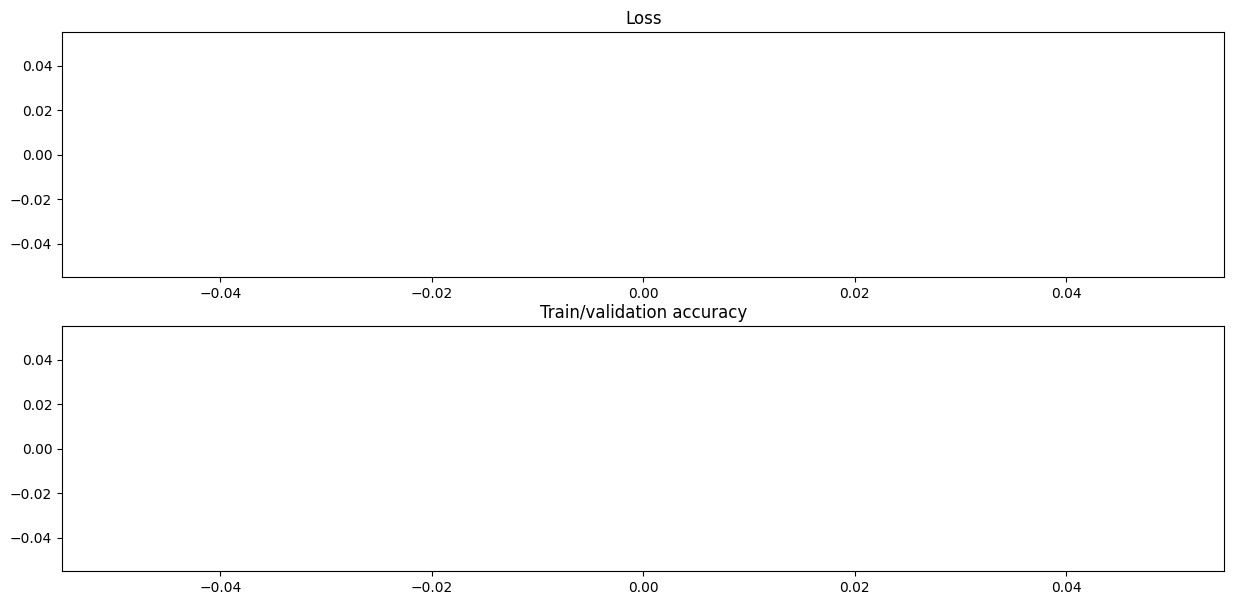

In [688]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [689]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.719000


In [691]:
best_params

{'learning_rate': 0.0783586882759864,
 'reg_strength': 1.0426418029212272e-05,
 'momentum': 0.9387609017530805,
 'decay': 0.9,
 'hl_size': 200,
 'batch_size': 300}

In [690]:
import json
with open(r'C:\Users\Aleksandr_Lapshin\Desktop\Learning materials\dlcourse.ai\params_hist_batch_size_add.json', 'w') as json_file:
    json_file.write(json.dumps(all_params_hist))